# Carreg Wen Case Study
Comparing the differences between a new unseen rain gauge and the CEH-GEAR and HadUK-Grid datasets


The rain gauge record is from Carreg-wen, Pembrokeshire


In [1]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import geopandas as gpd
import xarray as xr
import rioxarray

import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# Functions and globals for analysis

In [2]:
def convert_time_to_hour_base(data, hour, time_col='time'):
    """For polars dataframes"""
    return data.with_columns(
                pl.datetime(
                    pl.col(time_col).dt.year(),
                    pl.col(time_col).dt.month(),
                    pl.col(time_col).dt.day(),
                    hour,
                    0,
                    0,
                ).alias(time_col)
            )

In [3]:
RAIN_COL = "rain_mm"
NEARBY_THRESHOLD_M = 2500 # metres
START_DATE = datetime.datetime(year=1976, month=1, day=1, hour=9)
END_DATE = datetime.datetime(year=2010, month=1, day=1, hour=9)
OVERLAP_THRESHOLD = 365*3 # three years
CARREG_GAUGE_ID = 420649

EASTING_RANGE = [279000, 324000] ## based on Abermule region
NORTHING_RANGE = [271000, 308000] ## based on Abermule region

In [4]:
## Severn-wide flood events (from: https://github.com/Thomasjkeel/FDRI-catchment-contribution-to-floods)
severn_flood_dates = ['2000-09-28', '2001-02-13', '2002-01-28', '2002-11-15', '2007-01-01', '2008-03-17','2008-11-11']
severn_flood_dates = [datetime.datetime.strptime(flood_date + ' 09:00', "%Y-%m-%d %H:%M") for flood_date in severn_flood_dates]

# Load data

In [5]:
## Please see gridded_data for information on how to download 1km rainfall data
with open('../path_to_ceh_data.txt') as path:
    PATH_TO_CEHGEAR = path.read()

with open('../path_to_haduk_data.txt') as path:
    PATH_TO_HADUK = path.read()

## Load CEH-GEAR

In [6]:
ceh_severn = xr.open_dataset(f'{PATH_TO_CEHGEAR}/ceh_1km_severnregion_19700101_20230101.nc')
ceh_severn = ceh_severn.rename({'rainfall_amount': RAIN_COL})

ceh_abermule = ceh_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HadUK-Grid

In [7]:
haduk_severn = xr.open_mfdataset([f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19700101_19860831.nc',\
                f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19860901_20041231.nc',\
                 f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_20050101_20221231.nc'])
haduk_severn = haduk_severn.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_severn = haduk_severn.drop_vars(('latitude', 'longitude'))
haduk_severn['time'] = haduk_severn['time'].dt.floor(freq='D')

haduk_abermule = haduk_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HGHT grid

In [8]:
severn_hght = rioxarray.open_rasterio('../catchment_boundaries/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [9]:
## monthly gauges
severn_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_severn.csv', try_parse_dates=True)
severn_monthly_gauges = convert_time_to_hour_base(severn_monthly_gauges, hour=9, time_col='START_DATE')
severn_monthly_gauges = convert_time_to_hour_base(severn_monthly_gauges, hour=9, time_col='END_DATE')

In [10]:
## Load gauge data (QC'd version)
severn_all_gauges = pl.read_csv('../gauge_data/mo_daily_severn_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
severn_all_gauges = convert_time_to_hour_base(severn_all_gauges, hour=9)

In [11]:
# daily metadata
severn_metadata = pl.read_csv('../gauge_data/mo_severn_metadata.csv')
severn_metadata = severn_metadata.with_columns(
    (pl.col("ID").is_in(severn_monthly_gauges['ID']) & ~pl.col("ID").is_in(severn_all_gauges['gauge_id'].unique())).alias('IS_MONTHLY_GAUGE')
)

In [12]:
severn_metadata['IS_MONTHLY_GAUGE'].value_counts()

IS_MONTHLY_GAUGE,count
bool,u32
false,612
true,19


### load new Carreg Wen data

In [13]:
carreg_monthly_gauge = pl.read_csv('../gauge_data/carreg_wen_monthly_92to03.csv', try_parse_dates=True, columns=[1, 2], new_columns=['time', f'{RAIN_COL}_gauge_mon'])
## TODO: set to first day of month
carreg_monthly_gauge = carreg_monthly_gauge.with_columns(
                pl.datetime(
                    pl.col('time').dt.year(),
                    pl.col('time').dt.month(),
                    1,
                    pl.col('time').dt.hour(),
                    pl.col('time').dt.minute(),
                    pl.col('time').dt.second(),
                ).alias('time')
            )
carreg_monthly_gauge.head()

time,rain_mm_gauge_mon
datetime[μs],f64
1992-01-01 00:00:00,173.0
1992-02-01 00:00:00,202.0
1992-03-01 00:00:00,435.0
1992-04-01 00:00:00,222.0
1992-05-01 00:00:00,126.0


In [14]:
carreg_daily_new = pl.read_csv('../gauge_data/plynlimon-jwk-2024-infilled_carreg_rf.csv', skip_lines=13, columns=[0, 1], new_columns=['time', f'{RAIN_COL}_gauge_new'], try_parse_dates=True)
carreg_daily_new.head()

time,rain_mm_gauge_new
datetime[μs],f64
1976-01-02 09:00:00,null
1976-01-03 09:00:00,0.5
1976-01-04 09:00:00,62.0
1976-01-05 09:00:00,12.5
1976-01-06 09:00:00,5.0


# Load shapefiles

In [15]:
abermule_shp = gpd.read_file('../catchment_boundaries/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('../catchment_boundaries/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('../catchment_boundaries/Plynlimon Flume/54022/54022.shp')

# Gauge class required for analysis

In [16]:
ALL_METADATA = severn_metadata
ALL_GAUGE_DATA = severn_all_gauges
CEH_DATA = ceh_abermule
HADUK_DATA = haduk_abermule

In [17]:
class Gauge:
    def __init__(self, gauge_id, nearby_threshold_m=NEARBY_THRESHOLD_M):
        self.gauge_id = int(gauge_id)
        self.gauge_metadata = self._get_gauge_metadata()
        self.gauge_easting = self.gauge_metadata['EASTING'].item()
        self.gauge_northing = self.gauge_metadata['NORTHING'].item()
        self.gauge_data = self._get_gauge_data()
        self.nearby_gauges = self._get_nearby_gauges(nearby_threshold_m)
        self.closest_cehgear = self._get_closest_gridded_data(CEH_DATA, nearby_threshold_m)
        self.closest_haduk = self._get_closest_gridded_data(HADUK_DATA, nearby_threshold_m)

    def _get_gauge_metadata(self):
        assert self.gauge_id in ALL_METADATA['ID'],\
            f"Gauge id={self.gauge_id} is not in the gauge metadata"
        return ALL_METADATA.filter(pl.col("ID") == self.gauge_id)

    def _get_gauge_data(self):
        assert self.gauge_id in ALL_GAUGE_DATA['gauge_id'],\
            f"Gauge id={self.gauge_id} is not in the gauge data"
        return ALL_GAUGE_DATA.filter(pl.col("gauge_id") == self.gauge_id)

    def _get_nearby_gauges(self, nearby_threshold_m):
        nearby_gauge_metadata = ALL_METADATA.filter((pl.col('EASTING') >= self.gauge_easting-nearby_threshold_m)\
                                                & (pl.col('EASTING') <= self.gauge_easting+nearby_threshold_m) &\
            (pl.col('NORTHING') >= self.gauge_northing-nearby_threshold_m) & (pl.col('NORTHING') <= self.gauge_northing+nearby_threshold_m))
        return nearby_gauge_metadata['ID'].to_list()

    def _get_closest_gridded_data(self, gridded_data, closeness_threshold_m):
        """TODO: needs testing with data that is off grid"""
        closest_grid_cell = gridded_data.sel(x=self.gauge_easting, y=self.gauge_northing, method='nearest')
        distance_x, distance_y = abs(self.gauge_easting-closest_grid_cell['x']), abs(self.gauge_northing-closest_grid_cell['y'])
        if distance_x > closeness_threshold_m or distance_y > closeness_threshold_m:
            raise ValueError(f"Closest data point in grid is more than {closeness_threshold_m} m away in X ({distance_x} m), or Y ({distance_y} m)")
        return closest_grid_cell

    def get_nearby_gridded_data(self, gridded_data, nearby_radius_m):
        nearby_grid_cells = gridded_data.sel(x=slice(self.gauge_easting-nearby_radius_m, self.gauge_easting+nearby_radius_m),\
                                y=slice(self.gauge_northing-nearby_radius_m, self.gauge_northing+nearby_radius_m))
        return nearby_grid_cells


def get_combined_gauge_data(gauge, how='left'):
    assert isinstance(gauge, Gauge), "data should be of Gauge type"
    closest_ceh = pl.from_pandas(gauge.closest_cehgear[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_ceh').reset_index())
    closest_ceh = convert_time_to_hour_base(closest_ceh, hour=9)
    closest_haduk = pl.from_pandas(gauge.closest_haduk[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_haduk').reset_index())
    closest_haduk = convert_time_to_hour_base(closest_haduk, hour=9)
    combined_data = gauge.gauge_data[['time', f'{RAIN_COL}_gauge']].join(closest_ceh, on='time', how=how)
    combined_data = combined_data.join(closest_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data


def get_combined_gauge_data_w_nearby(gauge, nearby_radius_m=NEARBY_THRESHOLD_M, how='left'):
    combined_data = get_combined_gauge_data(gauge, how=how)
    gauge.nearby_ceh = gauge.get_nearby_gridded_data(CEH_DATA, nearby_radius_m)
    gauge.nearby_haduk = gauge.get_nearby_gridded_data(HADUK_DATA, nearby_radius_m)
    nearby_ceh = pl.from_pandas(gauge.nearby_ceh[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_ceh').reset_index())
    nearby_ceh = convert_time_to_hour_base(nearby_ceh, hour=9)
    nearby_haduk = pl.from_pandas(gauge.nearby_haduk[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_haduk').reset_index())
    nearby_haduk = convert_time_to_hour_base(nearby_haduk, hour=9)
    combined_data = combined_data.join(nearby_ceh, on='time', how=how)
    combined_data = combined_data.join(nearby_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data

## Metrics to compare gauge to grid

In [21]:
## calc_difference
def calc_difference_from_new_gauge(data, col):
    return data[f'{RAIN_COL}_gauge_new'] - data[col]


# Analysis

In [22]:
carreg_gauge = Gauge(CARREG_GAUGE_ID)

In [23]:
carreg_gauge.gauge_metadata

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH,IS_MONTHLY_GAUGE
i64,i64,str,str,i64,i64,i64,i64,str,bool
420649,9649,"""CARREG WEN""","""GB-GBN""",282900,288500,54,576,"""/BI/UK/GB/WAL/POWN/""",false


In [24]:
carreg_gauge.gauge_data.sort(by='time')

gauge_id,time,rain_mm_gauge,mo_flag
i64,datetime[μs],f64,i64
420649,1973-02-01 09:00:00,0.0,0
420649,1973-02-02 09:00:00,0.7,0
420649,1973-02-03 09:00:00,0.0,0
420649,1973-02-04 09:00:00,0.7,0
420649,1973-02-05 09:00:00,3.8,0
…,…,…,…
420649,1988-10-27 09:00:00,5.7,0
420649,1988-10-28 09:00:00,0.0,0
420649,1988-10-29 09:00:00,0.0,0


In [65]:
carreg_w_nearby = get_combined_gauge_data_w_nearby(carreg_gauge, how='right')
carreg_w_nearby = carreg_w_nearby.sort(by='time')
carreg_w_nearby = carreg_w_nearby.join(carreg_daily_new, on='time') ## join new data
carreg_w_nearby.head()

rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,time,rain_mm_nearby_haduk,rain_mm_gauge_new
f64,f64,f64,f64,datetime[μs],f64,f64
33.2,32.8,34.252948,30.846667,1976-01-02 09:00:00,31.655004,null
4.5,4.4,4.645649,4.833333,1976-01-03 09:00:00,4.455749,0.5
41.2,39.5,42.494596,36.693333,1976-01-04 09:00:00,38.621816,62.0
9.2,9.0,9.494617,8.696667,1976-01-05 09:00:00,8.824067,12.5
2.4,2.3,2.469852,2.056667,1976-01-06 09:00:00,2.097106,5.0


In [66]:
carreg_w_nearby_annual_mean = carreg_w_nearby.group_by_dynamic('time', every='1y').agg(pl.all().mean())
carreg_w_nearby_annual_sum = carreg_w_nearby.group_by_dynamic('time', every='1y').agg(pl.all().sum())

carreg_w_nearby_annual_mean.head()

time,rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,rain_mm_nearby_haduk,rain_mm_gauge_new
datetime[μs],f64,f64,f64,f64,f64,f64
1976-01-01 00:00:00,4.907182,4.926575,5.13251,4.675032,4.674708,5.061676
1977-01-01 00:00:00,9.466013,7.748767,7.894609,7.280274,7.311171,8.189726
1978-01-01 00:00:00,4.542697,6.888493,7.211537,6.560594,6.567135,7.179452
1979-01-01 00:00:00,null,7.919726,8.194458,7.575315,7.502279,9.094521
1980-01-01 00:00:00,null,7.392623,7.725199,7.046603,7.09663,8.189891


In [67]:
annual_data_dir = {'mean': carreg_w_nearby_annual_mean, 'sum': carreg_w_nearby_annual_sum}
stat_to_examine = 'mean'

In [68]:
columns_for_diff = ['rain_mm_gauge', 'rain_mm_closest_ceh', 'rain_mm_closest_haduk', 'rain_mm_nearby_ceh', 'rain_mm_nearby_haduk']

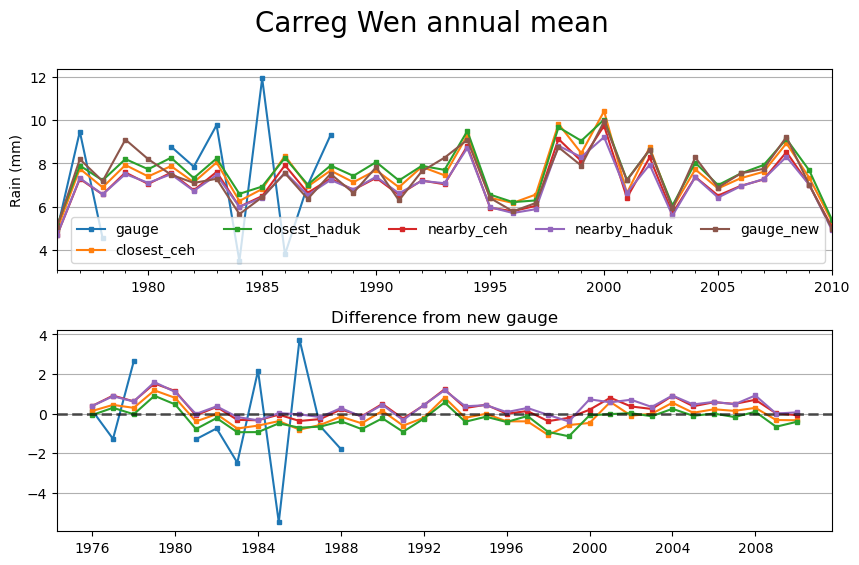

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
annual_data_df = annual_data_dir[stat_to_examine].to_pandas().set_index('time')
annual_data_df.plot(marker='s', markersize=3, ax=axes[0])
for ind, col in enumerate(columns_for_diff):
    axes[1].plot(calc_difference_from_new_gauge(annual_data_df, col), marker='s', markersize=3, label=col, color=f'C{ind}')

axes[0].legend([col.split('rain_mm_')[-1] for col in annual_data_dir['mean'].columns[1:]], ncols=5)
axes[0].set_ylabel(f"Rain (mm)"); axes[0].set_xlabel('')

axes[1].set_title("Difference from new gauge")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')

for ax in axes:
    ax.grid(axis='y')
plt.suptitle(f"Carreg Wen annual {stat_to_examine}", size=20)
plt.subplots_adjust(hspace=.3)

# fig.savefig(f'../figures/carreg_wen_case_study/annual_{stat_to_examine}_rainfall_comparison_new_gauge.png', bbox_inches='tight', dpi=200)

### Look at monthly sum

In [31]:
carreg_w_nearby_monthly_sum = carreg_w_nearby.group_by_dynamic('time', every='1mo').agg(pl.all().sum())
carreg_w_nearby_monthly_sum = carreg_w_nearby_monthly_sum.join(carreg_monthly_gauge, on='time', how='left')
carreg_w_nearby_monthly_sum = carreg_w_nearby_monthly_sum.select(['time', 'rain_mm_gauge_new', 'rain_mm_gauge_mon', 'rain_mm_closest_ceh', 'rain_mm_nearby_ceh', 'rain_mm_closest_haduk', 'rain_mm_nearby_haduk'])

In [32]:
carreg_w_nearby_monthly_sum.drop_nulls('rain_mm_gauge_mon')

time,rain_mm_gauge_new,rain_mm_gauge_mon,rain_mm_closest_ceh,rain_mm_nearby_ceh,rain_mm_closest_haduk,rain_mm_nearby_haduk
datetime[μs],f64,f64,f64,f64,f64,f64
1992-01-01 00:00:00,153.5,173.0,163.1,147.3,159.659813,141.978052
1992-02-01 00:00:00,195.5,202.0,189.8,166.176667,181.162753,169.200168
1992-03-01 00:00:00,407.5,435.0,404.7,360.13,394.7983,341.793396
1992-04-01 00:00:00,195.0,222.0,219.1,191.103333,191.013247,181.314376
1992-05-01 00:00:00,125.5,126.0,128.2,122.2,130.565307,121.071048
…,…,…,…,…,…,…
2003-07-01 00:00:00,179.0,200.0,195.9,185.766667,196.989432,181.990562
2003-09-01 00:00:00,104.25,87.7,89.5,84.363333,89.434233,78.496228
2003-10-01 00:00:00,209.25,139.0,148.2,153.353333,201.104988,182.923857


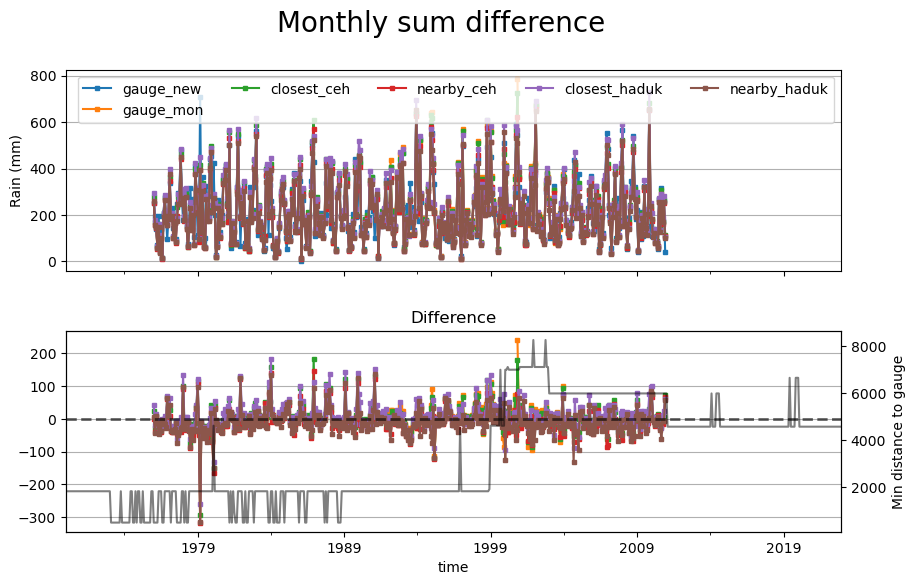

In [34]:
columns_for_diff = carreg_w_nearby_monthly_sum.columns[2:]
carreg_monthly_data_df = carreg_w_nearby_monthly_sum.to_pandas().set_index('time')
carreg_monthly_data_diff_df = carreg_w_nearby_monthly_sum.with_columns(
    pl.all().exclude(('time', f'{RAIN_COL}_gauge_new')) - pl.col(f'{RAIN_COL}_gauge_new')
).drop(f'{RAIN_COL}_gauge_new').to_pandas().set_index('time')

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
carreg_monthly_data_df.plot(marker='s', markersize=3, ax=axes[0])
for ind, col in enumerate(columns_for_diff):
    carreg_monthly_data_diff_df[col].plot(ax=axes[1], marker='s', markersize=3, label=col, color=f'C{ind+1}')

axes[0].legend([col.split('rain_mm_')[-1] for col in carreg_w_nearby_monthly_sum.columns[1:]], ncols=5)
axes[0].set_ylabel(f"Rain (mm)"); axes[0].set_xlabel('')

axes[1].set_title("Difference")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')

for ax in axes:
    ax.grid(axis='y')

twin_ax = axes[1].twinx()
carreg_gauge.closest_cehgear['min_dist'].resample(time='MS').mean().to_pandas().plot(ax=twin_ax, alpha=.5, color='k')
twin_ax.set_ylabel("Min distance to gauge")

plt.suptitle(f"Monthly sum difference", size=20)
plt.subplots_adjust(hspace=.3)

# fig.savefig(f'../figures/carreg_wen_case_study/monthly_{stat_to_examine}_rainfall_comparison_new_gauge.png', bbox_inches='tight', dpi=200)

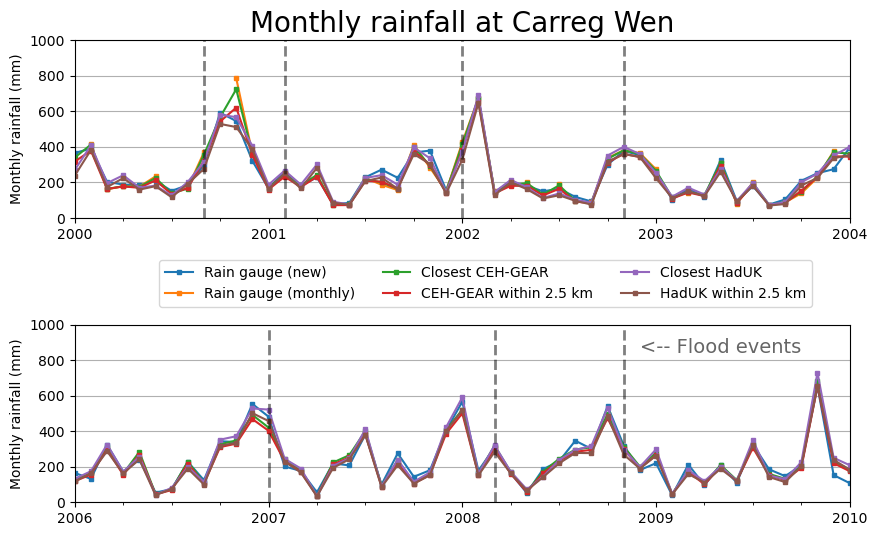

In [37]:
legend_labels = ['Rain gauge (new)', 'Rain gauge (monthly)','Closest CEH-GEAR', f'CEH-GEAR within {NEARBY_THRESHOLD_M/1000} km', 'Closest HadUK', f'HadUK within {NEARBY_THRESHOLD_M/1000} km']

carreg_monthly_data_df = carreg_w_nearby_monthly_sum.to_pandas().set_index('time')

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
for ax in axes:
    carreg_monthly_data_df.plot(marker='s', markersize=3, ax=ax)
    ax.grid(axis='y')
    ax.set_ylim(0, 1000)
    for flood_date in severn_flood_dates:
        ax.axvline(flood_date, linewidth=2, linestyle='--', color='k', alpha=.5)
    ax.set_ylabel("Monthly rainfall (mm)")
    ax.set_xlabel("")
    # twin_ax = ax.twinx()
    # carreg_gauge.closest_cehgear['min_dist'].resample(time='MS').mean().to_pandas().plot(ax=twin_ax, alpha=.5, color='k')
    # twin_ax.set_ylabel("Min distance to gauge")

axes[0].set_title("Monthly rainfall at Carreg Wen", size=20)
axes[1].text(s="<-- Flood events", x="2008-12", y=840, color='k', alpha=.6, size=14)
axes[0].set_xlim("2000", "2004")
axes[0].legend(legend_labels, ncols=3, loc='upper left', bbox_to_anchor=(0.1, -.2))
axes[1].set_xlim("2006", "2010")
axes[1].legend().remove()
plt.subplots_adjust(hspace=.6)

# fig.savefig(f'../figures/carreg_wen_case_study/monthly_carreg_wen_rainfall.png', bbox_inches='tight', dpi=200)

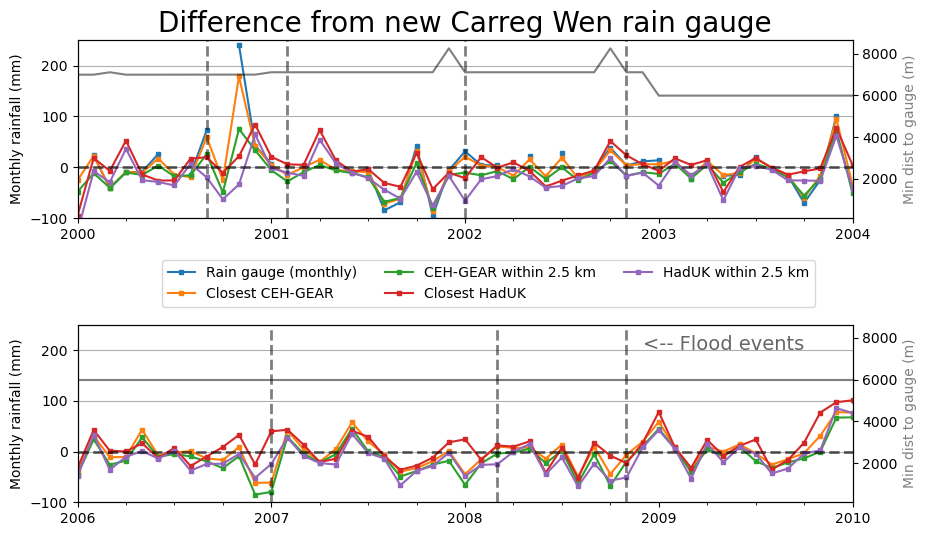

In [40]:
legend_labels = ['Rain gauge (monthly)','Closest CEH-GEAR', f'CEH-GEAR within {NEARBY_THRESHOLD_M/1000} km', 'Closest HadUK', f'HadUK within {NEARBY_THRESHOLD_M/1000} km']

carreg_monthly_data_diff_df = carreg_w_nearby_monthly_sum.with_columns(
    pl.all().exclude(('time', f'{RAIN_COL}_gauge_new')) - pl.col(f'{RAIN_COL}_gauge_new')
).drop(f'{RAIN_COL}_gauge_new').to_pandas().set_index('time')

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
for ax in axes:
    carreg_monthly_data_diff_df.plot(marker='s', markersize=3, ax=ax)

    ax.grid(axis='y')
    for flood_date in severn_flood_dates:
        ax.axvline(flood_date, linewidth=2, linestyle='--', color='k', alpha=.5)
    ax.set_ylabel("Monthly rainfall (mm)")
    ax.set_xlabel("")
    ax.set_ylim(-100, 250)
    ax.axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')
    twin_ax = ax.twinx()
    carreg_gauge.closest_cehgear['min_dist'].resample(time='MS').mean().to_pandas().plot(ax=twin_ax, alpha=.5, color='k')
    twin_ax.set_ylabel("Min dist to gauge (m)", color='grey')

axes[0].set_title("Difference from new Carreg Wen rain gauge", size=20)
axes[1].text(s="<-- Flood events", x="2008-12", y=200, color='k', alpha=.6, size=14)
axes[0].set_xlim("2000", "2004")
axes[0].legend(legend_labels, ncols=3, loc='upper left', bbox_to_anchor=(0.1, -.2))
axes[1].set_xlim("2006", "2010")
axes[1].legend().remove()
plt.subplots_adjust(hspace=.6)

# fig.savefig(f'../figures/carreg_wen_case_study/monthly_carreg_wen_rainfall_diff.png', bbox_inches='tight', dpi=200)



## Look at flood events

In [41]:
DAYS_BEFORE_FLOOD = 10

In [42]:
def get_date_ndays_before(one_date, ndays):
    return one_date-datetime.timedelta(days=ndays)

In [43]:
def get_data_ndays_before_flood_date(data, flood_date, ndays):
    days_before = get_date_ndays_before(flood_date, ndays=ndays)
    return data.filter(
        (pl.col("time") >= days_before) & (pl.col("time") <= flood_date)
    )

In [44]:
carreg_w_nearby_for_flooding = carreg_w_nearby.select(['time', 'rain_mm_gauge_new','rain_mm_closest_ceh', 'rain_mm_nearby_ceh', 'rain_mm_closest_haduk', 'rain_mm_nearby_haduk'])

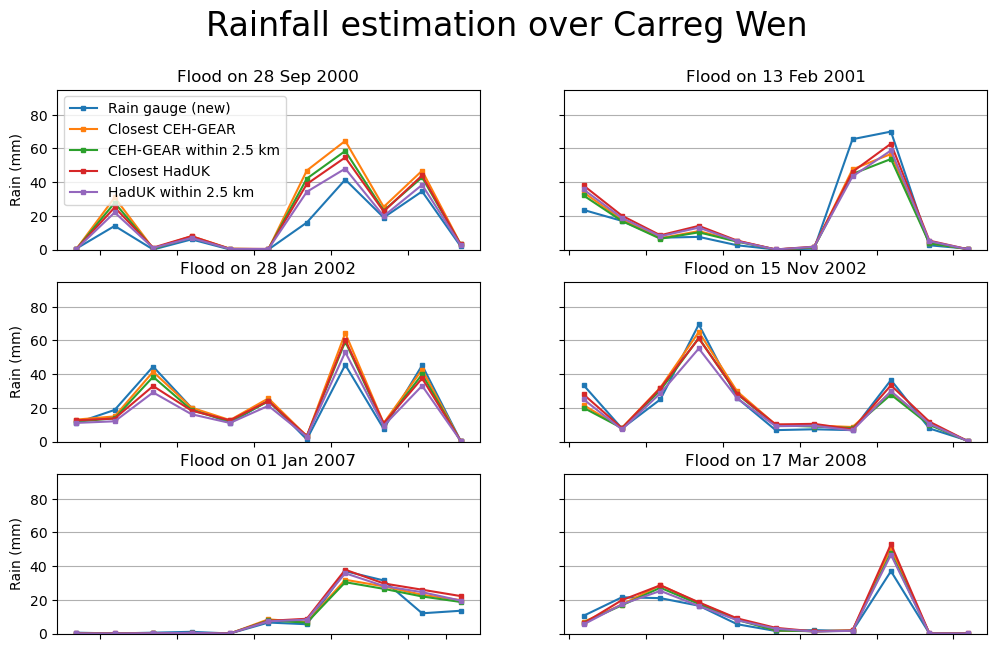

In [48]:
legend_labels = ['Rain gauge (new)','Closest CEH-GEAR', f'CEH-GEAR within {NEARBY_THRESHOLD_M/1000} km', 'Closest HadUK', f'HadUK within {NEARBY_THRESHOLD_M/1000} km']
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharey=True)
for ind, ax in enumerate(axes.flatten()):
    if ind == 0:
        get_data_ndays_before_flood_date(carreg_w_nearby_for_flooding, severn_flood_dates[ind], ndays=DAYS_BEFORE_FLOOD ).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3)
        ax.legend(legend_labels)
    else:
        get_data_ndays_before_flood_date(carreg_w_nearby_for_flooding, severn_flood_dates[ind], ndays=DAYS_BEFORE_FLOOD ).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3, legend=False)
    ax.set_title(f"Flood on {severn_flood_dates[ind].strftime('%d %b %Y')}")
    ax.set_xticklabels((''));
    ax.set_xlabel('')
    ax.set_ylim(0, 95)
    ax.set_ylabel('Rain (mm)')
    ax.grid(axis='y')
plt.suptitle("Rainfall estimation over Carreg Wen", size=24)
# fig.savefig('../figures/carreg_wen_case_study/flood_comparison_line.png', bbox_inches='tight', dpi=200)

In [49]:
all_summed_rain_for_flood_events = {}
for flood_date in severn_flood_dates:
    all_summed_rain_for_flood_events[flood_date] = get_data_ndays_before_flood_date(carreg_w_nearby_for_flooding, flood_date, ndays=DAYS_BEFORE_FLOOD).sum()

In [50]:
all_summed_rain_for_flood_events_df = pl.concat(all_summed_rain_for_flood_events.values())
all_summed_rain_for_flood_events_df = all_summed_rain_for_flood_events_df.with_columns(time=np.array([dt.date().strftime('%Y-%m-%d') for dt in severn_flood_dates]))

In [51]:
all_summed_rain_for_flood_events_df

time,rain_mm_gauge_new,rain_mm_closest_ceh,rain_mm_nearby_ceh,rain_mm_closest_haduk,rain_mm_nearby_haduk
str,f64,f64,f64,f64,f64
"""2000-09-28""",133.5,227.1,205.713333,198.118892,173.701007
"""2001-02-13""",196.5,184.1,173.933333,201.891936,189.001856
"""2002-01-28""",229.5,249.1,230.696667,226.61166,199.44312
"""2002-11-15""",227.0,224.7,212.503333,230.384364,207.278125
"""2007-01-01""",108.0,118.3,112.39,132.719379,124.120672
"""2008-03-17""",117.0,135.2,128.52,141.490395,124.690627
"""2008-11-11""",87.5,119.4,112.756667,117.569226,105.70558


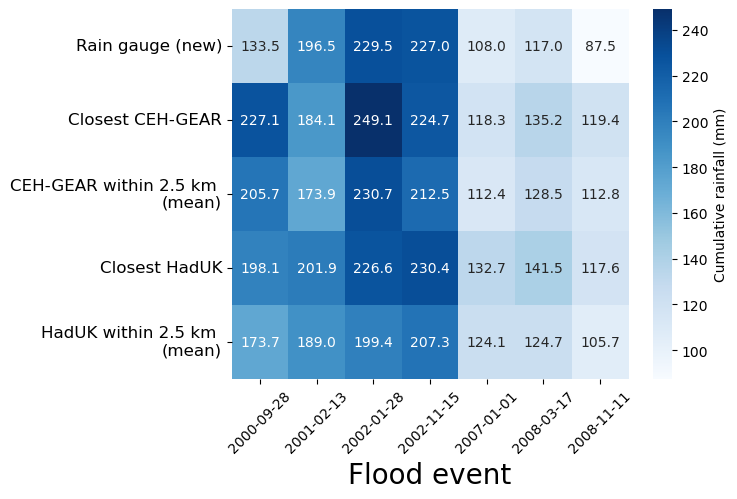

In [52]:
fig, ax = plt.subplots(1)
sns.heatmap(all_summed_rain_for_flood_events_df.to_pandas().set_index('time').T, fmt='.1f', annot=True, cmap='Blues', ax=ax, cbar_kws={'label': 'Cumulative rainfall (mm)'})
ax.set_yticklabels(['Rain gauge (new)', 'Closest CEH-GEAR', f'CEH-GEAR within {NEARBY_THRESHOLD_M/1000} km \n(mean)', 'Closest HadUK', f'HadUK within {NEARBY_THRESHOLD_M/1000} km \n(mean)'], size=12);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Flood event", size=20)
# fig.savefig('../figures/carreg_wen_case_study/flood_comparison_heatmap.png', bbox_inches='tight', dpi=200)

In [53]:
all_summed_rain_for_flood_events_df_percdiff = all_summed_rain_for_flood_events_df.with_columns(
     ((pl.all().exclude(('time', 'rain_mm_gauge_new')) - pl.col('rain_mm_gauge_new'))
      / (pl.col('rain_mm_gauge_new'))) *100
)

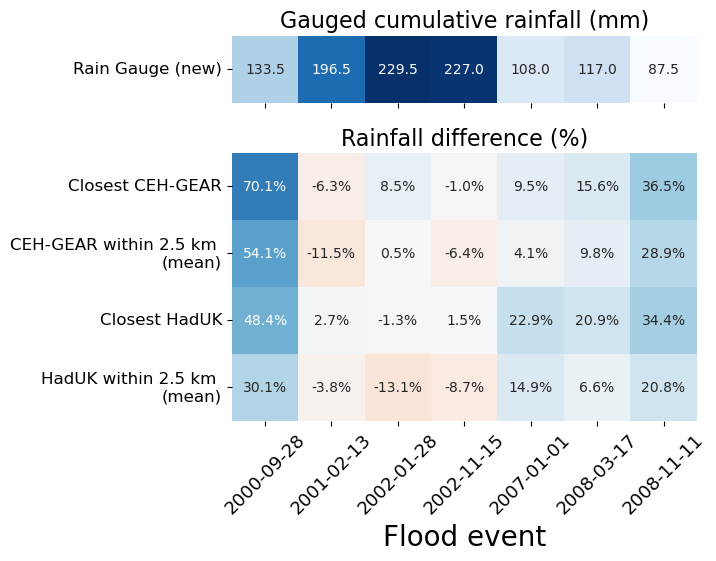

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(6, 5), height_ratios=[.2, .8], sharex=True)
sns.heatmap(all_summed_rain_for_flood_events_df_percdiff[['time', 'rain_mm_gauge_new']].to_pandas().set_index('time').T, fmt='.1f', cbar=False, annot=True, cmap='Blues', ax=axes[0], cbar_kws={'label': 'Cumulative rainfall (mm)'})
axes[0].set_title("Gauged cumulative rainfall (mm)", size=16)
axes[0].set_yticklabels(['Rain Gauge (new)'], rotation=0, size=12)
axes[0].set_xlabel('')


sns.heatmap(all_summed_rain_for_flood_events_df_percdiff.drop('rain_mm_gauge_new').to_pandas().set_index('time').T, fmt='.1f', annot=True, vmin=-100, vmax=100, cmap='RdBu', cbar=False, ax=axes[1], cbar_kws={'label': 'Cumulative rainfall (mm)'})
for t in axes[1].texts: t.set_text(t.get_text() + "%")
axes[1].set_title("Rainfall difference (%)", size=16)
axes[1].set_yticklabels(['Closest CEH-GEAR', f'CEH-GEAR within {NEARBY_THRESHOLD_M/1000} km \n(mean)', 'Closest HadUK', f'HadUK within {NEARBY_THRESHOLD_M/1000} km \n(mean)'], size=12);
axes[1].set_xlabel("Flood event", size=20)
axes[1].set_xticklabels(ax.get_xticklabels(), size=13, rotation=45);

fig.subplots_adjust(hspace=.3)

# fig.savefig('../figures/carreg_wen_case_study/flood_comparison_heatmap_percentage_difference.png', bbox_inches='tight', dpi=200)

# Look at nearby gauges

In [56]:
carreg_gauge_wide_neighbours = Gauge(CARREG_GAUGE_ID, nearby_threshold_m=8500)

In [57]:
# 'rain_mm_nearby_ceh', 'rain_mm_nearby_haduk'
carreg_w_nearby_for_flooding = carreg_w_nearby.select(['time', 'rain_mm_gauge_new','rain_mm_closest_ceh', 'rain_mm_closest_haduk'])

In [58]:
len(carreg_gauge_wide_neighbours.nearby_gauges)

46

In [59]:
all_nearby_gauge_data = carreg_w_nearby_for_flooding.rename({'rain_mm_gauge_new': 'rain_mm_gauge'})
for gauge_id in carreg_gauge_wide_neighbours.nearby_gauges:
    try:
        nearby_gauge = Gauge(gauge_id)
        dist_away_m = np.sqrt((nearby_gauge.gauge_easting - carreg_gauge.gauge_easting)**2 + (nearby_gauge.gauge_northing - carreg_gauge.gauge_northing)**2 )
        dist_away_m = round(dist_away_m.item()/1000, 2)
        all_nearby_gauge_data = all_nearby_gauge_data.join(\
                nearby_gauge.gauge_data[['time', 'rain_mm_gauge']],\
                    on='time', how='left', suffix=f'_{gauge_id} ({dist_away_m} km)')
    except AssertionError:
        print(f"{gauge_id} not included")


421169 not included
421192 not included
421222 not included
420650 not included
420653 not included
420656 not included
420696 not included
421048 not included
421065 not included
421080 not included
421101 not included
421125 not included
421134 not included
464013 not included
464015 not included
464021 not included
464030 not included
464068 not included
464070 not included
464108 not included
464114 not included
464125 not included
519171 not included
519960 not included
519963 not included
522086 not included
522679 not included
522720 not included


In [60]:
## reorder
nearby_gauge_cols = np.array(all_nearby_gauge_data.columns)[np.array(['km' in col for col in all_nearby_gauge_data.columns])]
order_of_cols = ['time', 'rain_mm_gauge'] + nearby_gauge_cols.tolist() + ['rain_mm_closest_ceh', 'rain_mm_closest_haduk']
all_nearby_gauge_data = all_nearby_gauge_data.select(order_of_cols)

In [61]:
all_nearby_gauge_data.head()

time,rain_mm_gauge,rain_mm_gauge_421234 (8.25 km),rain_mm_gauge_420649 (0.0 km),rain_mm_gauge_420655 (1.61 km),rain_mm_gauge_420668 (2.11 km),rain_mm_gauge_420708 (6.8 km),rain_mm_gauge_420720 (5.74 km),rain_mm_gauge_421090 (7.51 km),rain_mm_gauge_421140 (4.88 km),rain_mm_gauge_421152 (5.85 km),rain_mm_gauge_421161 (4.85 km),rain_mm_gauge_464019 (2.01 km),rain_mm_gauge_464029 (3.5 km),rain_mm_gauge_464041 (4.61 km),rain_mm_gauge_464046 (4.8 km),rain_mm_gauge_464054 (5.9 km),rain_mm_gauge_464101 (6.0 km),rain_mm_gauge_464109 (6.18 km),rain_mm_gauge_522046 (6.17 km),rain_mm_closest_ceh,rain_mm_closest_haduk
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1976-01-02 09:00:00,null,25.0,33.2,29.5,36.0,16.9,null,21.4,28.6,null,null,null,null,28.4,null,null,15.6,null,null,32.8,34.252948
1976-01-03 09:00:00,0.5,1.6,4.5,3.9,4.7,1.9,null,4.1,3.6,null,null,null,null,6.3,null,null,4.1,null,null,4.4,4.645649
1976-01-04 09:00:00,62.0,26.5,41.2,37.2,43.6,20.1,null,16.9,24.5,null,null,null,null,35.6,null,null,23.6,null,null,39.5,42.494596
1976-01-05 09:00:00,12.5,5.3,9.2,8.5,9.8,4.2,null,4.5,5.4,null,null,null,null,9.2,null,null,9.1,null,null,9.0,9.494617
1976-01-06 09:00:00,5.0,1.5,2.4,1.9,2.1,0.0,null,1.4,0.9,null,null,null,null,2.3,null,null,2.1,null,null,2.3,2.469852


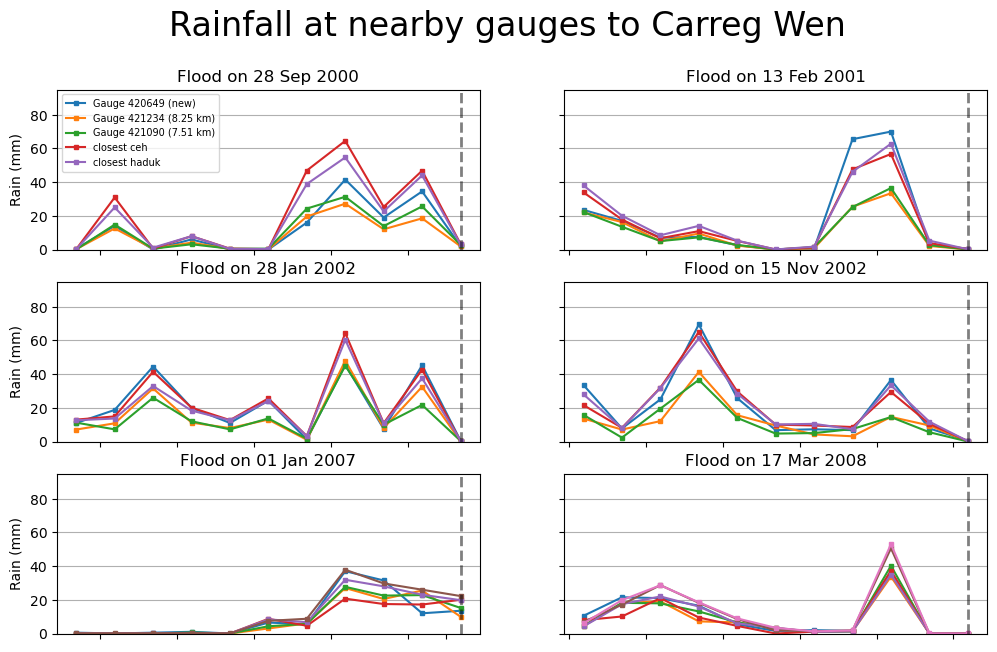

In [63]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharey=True)
for ind, ax in enumerate(axes.flatten()):
    all_nearby_gauge_data_one_flood = get_data_ndays_before_flood_date(all_nearby_gauge_data, flood_date=severn_flood_dates[ind], ndays=DAYS_BEFORE_FLOOD)
    if ind == 0:
        all_nearby_gauge_data_one_flood.to_pandas().set_index('time').dropna(how='all', axis=1).plot(ax=ax, marker='s', markersize=3)
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        new_labels = [lab.replace('rain_mm_gauge', 'Gauge').replace('_', ' ').replace('rain mm ', '') for lab in legend_labels]
        new_labels.pop(0)
        new_labels = [f"Gauge {CARREG_GAUGE_ID} (new)"] + new_labels
        ax.legend(legend_handles, new_labels, fontsize=7, ncols=1)
    else:
        all_nearby_gauge_data_one_flood.to_pandas().set_index('time').dropna(how='all', axis=1).plot(ax=ax, marker='s', markersize=3, legend=False)
    ax.set_title(f"Flood on {severn_flood_dates[ind].strftime('%d %b %Y')}")
    ax.set_xticklabels((''));
    ax.set_xlabel('')
    ax.set_ylim(0, 95)
    ax.set_ylabel('Rain (mm)')
    ax.grid(axis='y')
    ax.axvline(severn_flood_dates[ind], linestyle='--', color='k', alpha=.5, linewidth=2)
fig.suptitle("Rainfall at nearby gauges to Carreg Wen", size=24)
# fig.savefig('../figures/carreg_wen_case_study/flood_comparison_line_nearbygauges_w_grid.png', bbox_inches='tight', dpi=200)